# Capstone Project - Restaurant Analysis in San Francisco - Final Report

## Table of Contents
* [Business Problem](#business_problem)
* [Required Data and Cleaning](#required_data_and_cleaning)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Business Problem <a name="business_problem"></a>

The target audience for this project are the people looking to find the best spot in San Francisco, California, US (SFO) to setup a restaurant or fast food and feel confident that they will have enough customer to run their business.

City of San Francisco is one of the busy cities in California state and a big city. There are so many restaurants and fast foods available in the city. That also doesn't mean every part of the city has restaurants or all types of cuisine is available in every parts of city. There may be neighborhoods where there are no restaurants or less restaurants with more people living or walking around the place or there may be a specific cuisine type not available in a neighborhood. These neighborhoods are our areas of interest. The goal of this project is to **find the best neighborhood to setup a restaurant of a specific cuisine type**. 

In this project we will specifically focus on **setting up a Chinese/Asian cuisine restaurant in San Francisco, California, US**. 

## Required Data and Cleaning <a name="required_data_and_cleaning"></a>

**San Francisco Neighborhood:** 
The list of neighborhood in San Francisco will be extracted from the Wikipedia page https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco using the **BeautifulSoup** library for web page scrapping. The neighborhood list will be extracted one by one from the web page and saved as a list. Using the **geocoder** library from Nominatim, we will get the latitude and longitude detail for each neighborhood in the list. If location information is not available for any neighborhood, we will drop those neighborhoods for our analysis. 

**Restaurants/Fast foods in San Francisco:** 
Using the **Foursquare API**, we will get the list of all restaurants/fast foods using the Food category and their sub-categories in each neighborhood to understand how many restaurants are available and the type of cuisine of each restaurants. Separate out the Chinese/Asian cuisine from that list to understand which neighborhoods have this type of cuisine and how many are there.

**People Venues:** 
Using the **Foursquare API** get the list of venues in each neighborhood where we expect more people to be there and see a high chance of those people using the restaurants/fast foods. For example, if there are lot of shops or parks, then there is high possibility that people can visit the restaurants in those locations. If there are lot of night clubs, then there is low possibility of people visiting the restaurants in that location.

**Import all required libraries**

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib
from matplotlib import pyplot as py
import matplotlib.cm as cm
import matplotlib.colors as colors

## Methodology <a name="methodology"></a>

### Neighborhood Location and Size

The list of neighborhood in San Francisco will be extracted from the Wikipedia page https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco using the BeautifulSoup library for web page scrapping. The neighborhood list will be extracted one by one from the web page and saved as a list. Using the geocoder library from Nominatim, we will get the latitude and longitude detail for each neighborhood in the list. If location information is not available for any neighborhood, we will drop those neighborhoods for our analysis. 

The neighborhoods of San Francisco (SFO) is explored and determined to consider 200 meters radius for each neighborhood for exploration of this project. 

**Get the list of neighborhoods**

In [2]:
#Read the wikipedia page for San Francisco neighborhood
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco'
request = requests.get(url)

#Create the soup object to scrape the page
soup = BeautifulSoup(request.content,'lxml')

#Read the required xml tags and convert the neighborhood names to a list
xml_tags = soup.find_all(class_='toctext')
neigh_list = []
for ind in np.arange(len(xml_tags)):
    neigh_list.append(xml_tags[ind].get_text())
    
#Convert the list of neighbothoods to a dataframe
neigh_df = pd.DataFrame(neigh_list)
neigh_df.columns = ['Neighborhood']
neigh_df.head()

,Neighborhood
0,Alamo Square
1,Anza Vista
2,Ashbury Heights
3,Balboa Park
4,Balboa Terrace


**Build the function to get the neighborhood coordinates**

In [3]:
#Build the function to get the location coordinates for neighborhood
def getLocation(address):
    geolocator = Nominatim(user_agent="CA_explorer")
    loc = geolocator.geocode(address, timeout=10)
    return(loc)

**Get the coordinates for the neighborhoods**

There are chances we may not get the coordinates for some of the neighborhood. We will ignore those neighborhood and drop them from our analysis

In [5]:
neigh_lat=[]
neigh_long=[]

#For each neighborhood in the list, call the function to get the coordinates
for ind in np.arange(len(neigh_list)):
    neigh_address = '{}, San Francisco, California'.format(neigh_df.iloc[ind,0])
    neigh_loc = getLocation(neigh_address)
    
    #If the coordinates are not available for any neighborhood, set it to NaN
    if neigh_loc is None:
        neigh_lat.append(np.nan)
        neigh_long.append(np.nan)
    else:
        neigh_lat.append(neigh_loc.latitude)
        neigh_long.append(neigh_loc.longitude)
        print(neigh_address,':', neigh_loc.latitude, neigh_loc.longitude)

Alamo Square, San Francisco, California : 37.77635985 -122.43468852023724
Anza Vista, San Francisco, California : 37.7808364 -122.4431489
Balboa Park, San Francisco, California : 37.7214274 -122.4475473
Balboa Terrace, San Francisco, California : 32.809471 -117.208557
Bayview, San Francisco, California : 37.7288889 -122.3925
Belden Place, San Francisco, California : 37.791744 -122.4038861
Bernal Heights, San Francisco, California : 37.7429861 -122.4158042
Buena Vista, San Francisco, California : 37.8065321 -122.4206485
Castro, San Francisco, California : 37.7608561 -122.434957
China Basin, San Francisco, California : 37.7763295 -122.39183853009041
Chinatown, San Francisco, California : 37.7943011 -122.4063757
Civic Center, San Francisco, California : 37.7795939 -122.4167938
Cole Valley, San Francisco, California : 37.7658133 -122.4499624
Corona Heights, San Francisco, California : 37.7648857 -122.4393677
Cow Hollow, San Francisco, California : 37.7972616 -122.4362477
Crocker-Amazon, Sa

**Merge the coordinates data to the neighborhood dataframe**

In [6]:
# Add the list of latiudes and longitudes to the neighborhood dataframe
neigh_df['Latitude'] = neigh_lat
neigh_df['Longitude'] = neigh_long
neigh_df.head()

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776360,-122.434689
1,Anza Vista,37.780836,-122.443149
2,Ashbury Heights,NaN,NaN
3,Balboa Park,37.721427,-122.447547
4,Balboa Terrace,32.809471,-117.208557


**Verification of neighborhood coordinates against SFO boundary**

Some of the neighborhoods return the coordinates doesn't really belong to SFO. This may be due to conflict of coordinate names in geocoder. So we will set the boundary coordinates for SFO and ignore the neighborhoods outside of this boundary.

In [7]:
#Check coordinates of every neighborhood against this boundry and make the coordinates NaN, if outside the interested boundary

sfo_min_lat = 37.6
sfo_max_lat = 37.9
sfo_min_lng = -122.6
sfo_max_lng = -122.3

for ind, lat, long in zip(np.arange(neigh_df.shape[0]), neigh_df['Latitude'], neigh_df['Longitude']):
    if (lat is not np.nan or long is not np.nan):
        if not ((sfo_min_lat<=lat<=sfo_max_lat) and (sfo_min_lng<=long<=sfo_max_lng)):
            neigh_df.loc[ind,'Latitude'] = np.nan
            neigh_df.loc[ind,'Longitude'] = np.nan

print(neigh_df.shape)
neigh_df.head()

(123, 3)


,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776360,-122.434689
1,Anza Vista,37.780836,-122.443149
2,Ashbury Heights,NaN,NaN
3,Balboa Park,37.721427,-122.447547
4,Balboa Terrace,NaN,NaN


**Drop all the NaN rows**

In [8]:
#Drop all the NaN rows and create a clean dataframe of our interest
neigh_df.dropna(inplace=True)
neigh_df.reset_index(drop=True, inplace=True)
print(neigh_df.shape)
neigh_df.head()

(83, 3)


,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776360,-122.434689
1,Anza Vista,37.780836,-122.443149
2,Balboa Park,37.721427,-122.447547
3,Bayview,37.728889,-122.392500
4,Belden Place,37.791744,-122.403886


**Plot the neighborhoods in the SFO map**

In [9]:
#Get the coordinates for the city center of SFO
geolocator = Nominatim(user_agent="CA_explorer", timeout=5)
loc = geolocator.geocode('San Francisco, California')
sfo_lat = loc.latitude
sfo_long = loc.longitude

#Prepare the map focused on San Francisco
map_sfo = folium.Map(location=[sfo_lat, sfo_long], zoom_start=12)

# Add the marker for the neighborhood in San Francisco
for lat, long, name in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Neighborhood']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([lat, long],
                        radius=3,
                        popup=label,
                        color='red',). add_to(map_sfo)

#Display the San Francisco map with neighborhood markers
map_sfo

**Plot the neighborhoods in SFO map using the raduis marker**

The map is plotted using radius marker to determine what is the best radius to consider to search for venues in each neighborhood. The optimal radius seems to be 200 meters

In [10]:
#Prepare the map focused on San Francisco
map_sfo_rad = folium.Map(location=[sfo_lat, sfo_long], zoom_start=12)

# Add the marker for the neighborhood in San Francisco
for lat, long, name in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Neighborhood']):
    label = folium.Popup(name, parse_html=True)
    folium.Circle([lat, long],
                  radius=200,
                  popup=label,
                  color='red',
                  fill=True,
                  fill_color='red',                    
                  fill_opacity=0.2).add_to(map_sfo_rad)

#Display the San Francisco map with neighborhood markers
map_sfo_rad

### Food Venue

Using the Foursquare API Get Venue Recommendations, retrieve all the food category venues detail in each neighborhood of SFO. The required key attributes for each venue are venue category and location coordinates. The venue category explains the type of eat out and the type of cuisine. The neighborhoods of SFO had 88 different types of venue categories to explore.
 
To make the exploration easier, the venue categories are converted to table columns and the count of venues in each category is summed up at the neighborhood level. Each neighborhood now has the detail of number of food venues under each category. All the food venues in each category is accumulated to get the total number of food venues in each neighborhood. Since our focus is setting up a Chinese/Asian restaurant, we determine the number of Chinese/Asian restaurants in each neighborhood. There were 2 categories to consider such as Chinese Restaurants and Asian Restaurants for this analysis. 

**Set the Foursquare API basic request parameters**

In [12]:
CLIENT_ID = '1WSXSUNXPFJ2BHBIOBXKVY2HKQK1HKEKQBBOGDUSR1PPPQR5' 
CLIENT_SECRET = 'XZWPMWPR2P2RWXXW35XBBLYGNZ4T2WA2CE1HUJQXATFG31EJ' 
VERSION = '20180605' 

**Define the function to get all the food venues in each neighborhood**

In [13]:
#Define a function to get all the eat outs in each neighborhood for a radius of 200m
def getEatouts(latitude, longitude, neighborhood):
    
    #Initialize the basic parameters
    radius = 200  
    limit = 50
    category = 'food'
    eatouts = []
    
    #Process each neighborhood in a loop
    for lat, long, name in zip(latitude, longitude, neighborhood):
        
        print('Processing ', name, '...')
        #Form the explore url to make the API call
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        category,
        radius,
        limit)
        
        #Invoke the API and save the result
        results = requests.get(url).json()
        res_item = results['response']['groups'][0]['items']
        
        #Process the result and form a list of tuples
        for item in res_item:
            venue_name = item['venue']['name']
            venue_lat = item['venue']['location']['lat']
            venue_long = item['venue']['location']['lng']
            venue_cat = item['venue']['categories'][0]['name']
            venue_fq_id = item['venue']['id']
            venue_dist = item['venue']['location']['distance']
            eatouts.append([(name, lat, long, venue_name, venue_lat, venue_long, venue_cat, venue_fq_id, venue_dist)])
        print('Completed ', name, '!!!')
            
    #Convert the list of tuples into a dataframe and give meaningful column names
    eatouts_df = pd.DataFrame(item[0] for item in eatouts)
    eatouts_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 
                          'Category', 'FourSquareId', 'Distance from Center']
    
    #Return the dataframe of neighborhood venues
    return(eatouts_df)

**Get the food venues list for each neighborhood and create a new dataframe**

In [14]:
sfo_eatouts = getEatouts(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Neighborhood'])
sfo_eatouts.head()

Processing  Alamo Square ...
Completed  Alamo Square !!!
Processing  Anza Vista ...
Completed  Anza Vista !!!
Processing  Balboa Park ...
Completed  Balboa Park !!!
Processing  Bayview ...
Completed  Bayview !!!
Processing  Belden Place ...
Completed  Belden Place !!!
Processing  Bernal Heights ...
Completed  Bernal Heights !!!
Processing  Buena Vista ...
Completed  Buena Vista !!!
Processing  Castro ...
Completed  Castro !!!
Processing  China Basin ...
Completed  China Basin !!!
Processing  Chinatown ...
Completed  Chinatown !!!
Processing  Civic Center ...
Completed  Civic Center !!!
Processing  Cole Valley ...
Completed  Cole Valley !!!
Processing  Corona Heights ...
Completed  Corona Heights !!!
Processing  Cow Hollow ...
Completed  Cow Hollow !!!
Processing  Crocker-Amazon ...
Completed  Crocker-Amazon !!!
Processing  Dogpatch ...
Completed  Dogpatch !!!
Processing  Dolores Heights ...
Completed  Dolores Heights !!!
Processing  Duboce Triangle ...
Completed  Duboce Triangle !!!
Pr

,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Category,FourSquareId,Distance from Center
0,Alamo Square,37.776360,-122.434689,Lady Falcon Coffee Club,37.776303,-122.433174,Food Truck,584dbf7f6431e51a66133458,133
1,Anza Vista,37.780836,-122.443149,Kaiser Permanente Cafeteria - 1st Floor,37.782563,-122.443595,Cafeteria,4e8ea35fd3e3f34301a3709f,196
2,Balboa Park,37.721427,-122.447547,AJ's Barbeque Cafe,37.720757,-122.446280,BBQ Joint,56185534498ef8b350a6d8a4,134
3,Balboa Park,37.721427,-122.447547,Crazy Pepper,37.720832,-122.446663,Asian Restaurant,4e434bc61495455b10c04595,102
4,Balboa Park,37.721427,-122.447547,Tai Shan Restaurant,37.721012,-122.445922,Food,4f324fa319836c91c7cb36e4,150


**Analyze the food venues data**

In [15]:
#Analyze the sfo_eatouts data
print('Number of rows: {}'.format(sfo_eatouts.shape[0]))
print('Number of food venues in each neighborhood...')
sfo_eatouts.groupby('Neighborhood').count()['Venue']

Number of rows: 879
Number of food venues in each neighborhood...


Neighborhood
Alamo Square                 1
Anza Vista                   1
Balboa Park                  8
Bayview                      7
Belden Place                35
Buena Vista                 17
Castro                      35
China Basin                 12
Chinatown                   26
Civic Center                11
Cole Valley                 10
Corona Heights               1
Cow Hollow                  15
Dogpatch                    12
Dolores Heights              4
Duboce Triangle              6
Embarcadero                  3
Eureka Valley               33
Excelsior                   21
Fillmore                    27
Financial District          36
Financial District South    36
Fisherman's Wharf           29
Forest Hill                  1
Glen Park                   11
Haight-Ashbury              13
Hayes Valley                39
Ingleside                    9
Inner Sunset                14
Irish Hill                   4
                            ..
Mission District          

**Convert the food venues category to columns and create a dataframe**

Using get_dummies make a column for each food category in our list and that makes analysis easier to know how many category of food venues available in each neighborhood

In [16]:
cat_dummy = pd.get_dummies(sfo_eatouts.set_index('Neighborhood')['Category']).reset_index()
cat_dummy.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoshoku Restaurant
0,Alamo Square,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anza Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balboa Park,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balboa Park,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Group by the categories dataframe by Neighborhood and get the number of food venues in each neighborhood**

In [18]:
neigh_dummy = cat_dummy.groupby('Neighborhood').sum().reset_index()
neigh_foods = neigh_df.merge(right=neigh_dummy, how='left', on='Neighborhood')
neigh_foods.replace(to_replace=np.nan, value=0, inplace=True)
print(neigh_foods.shape)
neigh_foods.head()

(83, 91)


,Neighborhood,Latitude,Longitude,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoshoku Restaurant
0,Alamo Square,37.776360,-122.434689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Anza Vista,37.780836,-122.443149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Balboa Park,37.721427,-122.447547,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview,37.728889,-122.392500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Belden Place,37.791744,-122.403886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Add columns to dataframe for total number of food venues and chinese/asian restaurants in the neighborhood**

In [19]:
neigh_foods['Total Restaurants'] = neigh_foods.iloc[:, 3:].sum(axis=1)
neigh_foods['Chinese Restaurants'] = neigh_foods.loc[:, ['Asian Restaurant', 'Chinese Restaurant']].sum(axis=1)
neigh_foods.head(10)

,Neighborhood,Latitude,Longitude,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoshoku Restaurant,Total Restaurants,Chinese Restaurants
0,Alamo Square,37.776360,-122.434689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Anza Vista,37.780836,-122.443149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Balboa Park,37.721427,-122.447547,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0
3,Bayview,37.728889,-122.392500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
4,Belden Place,37.791744,-122.403886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0
5,Bernal Heights,37.742986,-122.415804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Buena Vista,37.806532,-122.420648,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
7,Castro,37.760856,-122.434957,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0
8,China Basin,37.776330,-122.391839,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
9,Chinatown,37.794301,-122.406376,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,26.0,11.0


### Other Venues Exploration

Now it’s time learn more about each neighborhood to know how busy the neighborhood is. From the list of categories available in Foursquare, we pick few categories where there will be more people living or walking around in those venues. This gives us an idea on how busy the neighborhood is, and probability of customers being attracted towards restaurants. For this analysis we used the following categories…
* Stadiums
* Colleges
* Parks & Recreations
* Shops
* Apartments/Residence
* Hotels

Retrieve the counts of these busy venues in each neighborhood and combine with the restaurant data. This provides all the data we need to use for our analysis to determine the best neighborhood to setup a restaurant.

**Define a function to get the venues for the 6 mentioned categories**

In [52]:
#Define a function to get all the busy venues in each neighborhood for a radius of 200m
def getBusyVenues(latitude, longitude, neighborhood):
    
    #Initialize the basic parameters
    radius = 200  
    limit = 50
    category = ['4bf58dd8d48988d184941735', #Stadium
                '4d4b7105d754a06372d81259', #College
                '4d4b7105d754a06377d81259', #Outdoor
                '4d4b7105d754a06378d81259', #Shops
                '4e67e38e036454776db1fb3a', #Residence
                '4bf58dd8d48988d1fa931735'  #Hotel
               ]
    busy_venues = []
    
    #Process each neighborhood in a loop
    for lat, long, name in zip(latitude, longitude, neighborhood):
        
        print('Processing ', name, '...')
        
        venue_count = 0
        for ind in np.arange(len(category)):
            #Form the explore url to make the API call
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                long,
                category[ind],
                radius,
                limit)
        
            #Invoke the API and save the result
            results = requests.get(url, timeout=10).json()
            venue_count += results['response']['totalResults']
                    
        busy_venues.append(venue_count)
        print('Completed ', name, '!!!')
            
    #Return the list of busy venues count for neighborhoods
    return(busy_venues)

**Get the venues count in each neighborhood for those 6 categories**

In [53]:
busy_venues = getBusyVenues(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Neighborhood'])

Processing  Alamo Square ...
Completed  Alamo Square !!!
Processing  Anza Vista ...
Completed  Anza Vista !!!
Processing  Balboa Park ...
Completed  Balboa Park !!!
Processing  Bayview ...
Completed  Bayview !!!
Processing  Belden Place ...
Completed  Belden Place !!!
Processing  Bernal Heights ...
Completed  Bernal Heights !!!
Processing  Buena Vista ...
Completed  Buena Vista !!!
Processing  Castro ...
Completed  Castro !!!
Processing  China Basin ...
Completed  China Basin !!!
Processing  Chinatown ...
Completed  Chinatown !!!
Processing  Civic Center ...
Completed  Civic Center !!!
Processing  Cole Valley ...
Completed  Cole Valley !!!
Processing  Corona Heights ...
Completed  Corona Heights !!!
Processing  Cow Hollow ...
Completed  Cow Hollow !!!
Processing  Crocker-Amazon ...
Completed  Crocker-Amazon !!!
Processing  Dogpatch ...
Completed  Dogpatch !!!
Processing  Dolores Heights ...
Completed  Dolores Heights !!!
Processing  Duboce Triangle ...
Completed  Duboce Triangle !!!
Pr

**Dataframe is created with the data used for clustering**

We will be using the following data for each neighborhood for further analysis…
* Total Restaurants count
* Chinese Restaurants count
* Busy venues count

Each neighborhood is explored with these data to get an idea on how each neighborhood looks. 

In [55]:
#Dataframe for cluster modeling
neigh_cluster = neigh_foods[['Total Restaurants', 'Chinese Restaurants']]
neigh_cluster['Other Venues'] = busy_venues

neigh_cluster.head()

C:\Users\A0GRBZZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Total Restaurants,Chinese Restaurants,Other Venues
0,1.0,0.0,14
1,1.0,0.0,4
2,8.0,1.0,2
3,7.0,0.0,5
4,35.0,0.0,191


### Clustering

For this analysis we will be using the K-Mean clustering to cluster these neighborhoods based on the data Total Restaurants count, Chinese Restaurants count, and Busy venues count we have for each neighborhood. The data set is tested with varying number of clusters to determine the correct and minimum number of clusters required. The testing was done starting from 1 cluster to 10 clusters. For each iteration of testing with different number if clusters, the mean distance for data points to centroid is calculated and plotted against the K value (number of clusters). The elbow point where the reduction in mean distance slows down is picked as the optimal number of clusters for this analysis. Based on the graph, the optimal number of clusters is determined as 5.
 
In the final step each cluster is analyzed to determine which cluster is the best one to setup a new Chinese/Asian Restaurant. The bar graph is plotted using the mean values for each cluster to give a visual indicator on which clusters seems close to the expectation. The cluster is analyzed in detail to find the good neighborhood for setting up the new restaurant.

**Analyze the optimal number of clusters**

For different number of clusters from 1 to 10, the mean distance of each data point to it's centroid is calculated and the elbow point is picked as the optimal number of clusters.

In [56]:
#Convert the required columns to 3 different lists
x1 = neigh_cluster['Total Restaurants'].tolist()
x2 = neigh_cluster['Chinese Restaurants'].tolist()
x3 = neigh_cluster['Other Venues'].tolist()

cluster_list = []
mean_dist = []

#run the analysis for number of clusters from 1 to 10
for k in np.arange(10):
    clusters = k+1
    cluster_list.append(clusters)
    k_means = KMeans(init = "k-means++", n_clusters = clusters, n_init = 15).fit(neigh_cluster)
    
    centroid = []
    for label in k_means.labels_:
        centroid.append(k_means.cluster_centers_[label])
    
    tot_dist = 0
    
    #Measure the distance for each data point from center and calculate the mean
    for i in np.arange(len(x1)):
        dist = np.sqrt(np.square(x1[i]-centroid[i][0])+np.square(x2[i]-centroid[i][1])+np.square(x3[i]-centroid[i][2]))
        tot_dist += dist
    
    mean_dist.append(tot_dist/len(x1))
          
print('List of K values: ', cluster_list)
print('Mean distance for each K value: ', mean_dist)

List of K values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Mean distance for each K value:  [35.51068069212382, 22.471452753104384, 14.329615071767945, 10.734517440312597, 8.662266437115681, 8.10725756221584, 7.460624478908234, 6.997314791416653, 6.1751148791061, 5.676032332448234]


**Plot the line graph between K values and Mean Distance**

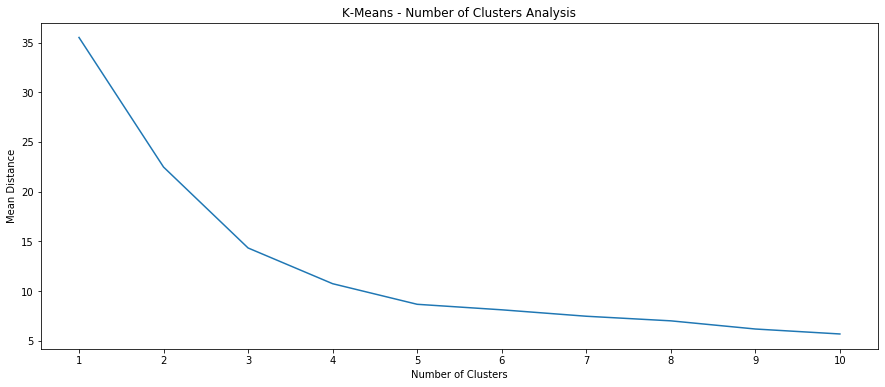

In [57]:
mean_distance = pd.DataFrame(columns=['Clusters', 'Mean Distance'])
mean_distance['Clusters'] = cluster_list
mean_distance['Mean Distance'] = mean_dist
mean_distance.set_index('Clusters', inplace=True)
mean_distance.index.name = None
mean_distance

mean_distance.plot(kind='line', figsize=(15, 6), legend=None, xticks=cluster_list)
py.title('K-Means - Number of Clusters Analysis')
py.xlabel('Number of Clusters')
py.ylabel('Mean Distance')
py.show()

The elbow point 5 is picked as the optimal number of clusters

**The K-Means model is created using 5 clusters**

In [58]:
#Set the number of clusters to 5
clusters = 5

#Define KMeans and fit the model
k_means = KMeans(init = "k-means++", n_clusters = clusters, n_init = 15).fit(neigh_cluster)

print(set(k_means.labels_))
print(len(k_means.labels_))

{0, 1, 2, 3, 4}
83


**Dataframe is created using the neighborhood location data and cluster data**

In [59]:
sfo_clusters = neigh_foods.loc[:, ['Neighborhood', 'Latitude', 'Longitude', 'Total Restaurants', 'Chinese Restaurants']]
sfo_clusters['Other Venues'] = neigh_cluster['Other Venues']
sfo_clusters['Cluster'] = k_means.labels_
sfo_clusters.head()

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
0,Alamo Square,37.776360,-122.434689,1.0,0.0,14,0
1,Anza Vista,37.780836,-122.443149,1.0,0.0,4,0
2,Balboa Park,37.721427,-122.447547,8.0,1.0,2,0
3,Bayview,37.728889,-122.392500,7.0,0.0,5,0
4,Belden Place,37.791744,-122.403886,35.0,0.0,191,2


**Plot a Bar graph to show the mean data by neighborhood grouping**

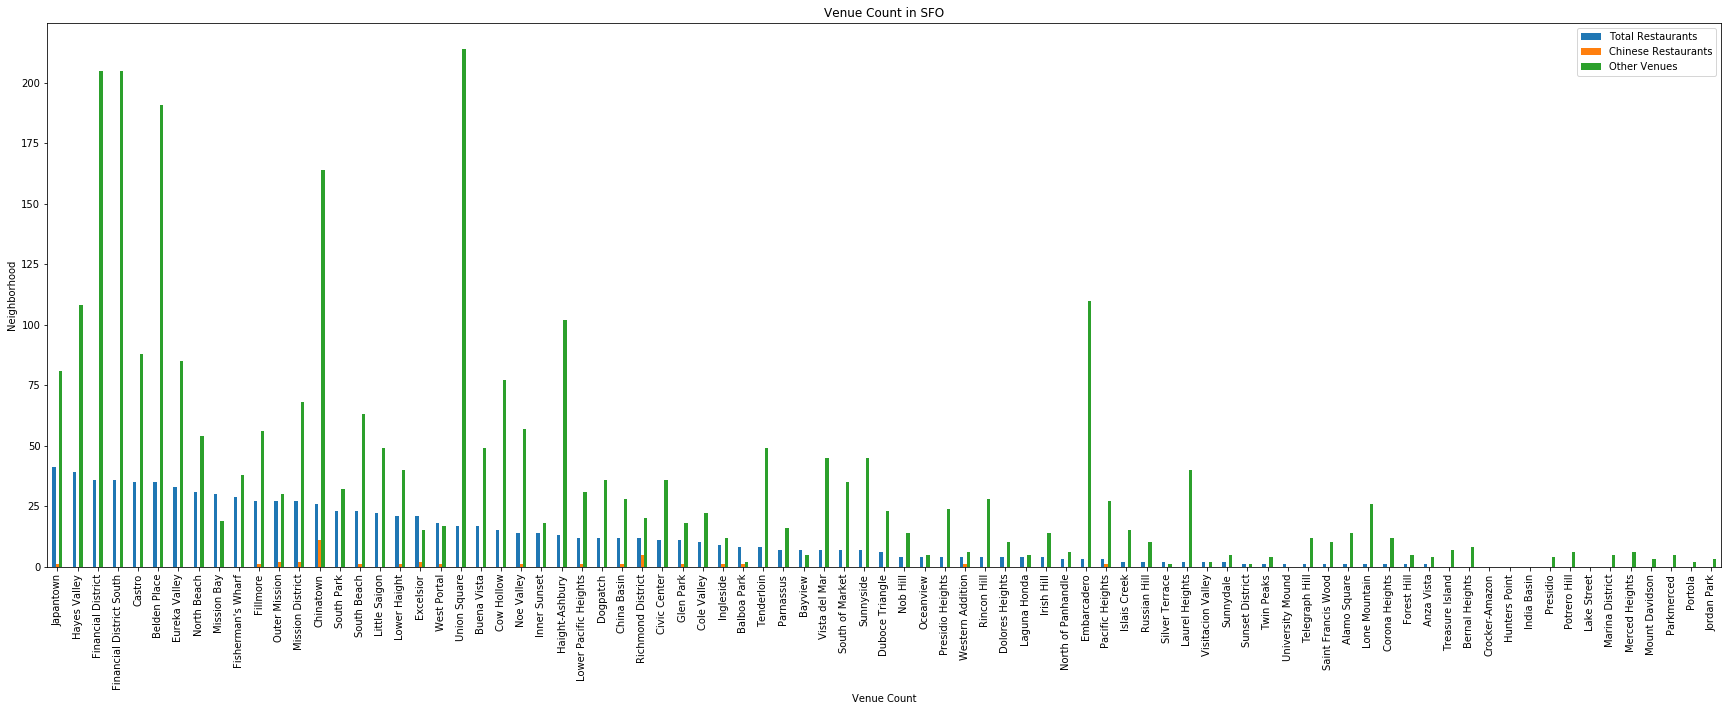

In [60]:
neigh_bar = sfo_clusters[['Neighborhood', 'Total Restaurants', 'Chinese Restaurants', 'Other Venues']].set_index('Neighborhood').sort_values('Total Restaurants', ascending=False)
neigh_bar.plot.bar(figsize=(30,10))
py.title('Venue Count in SFO')
py.xlabel('Venue Count')
py.ylabel('Neighborhood')
py.show()

**Plot a Bar graph to show the mean data by cluster grouping**

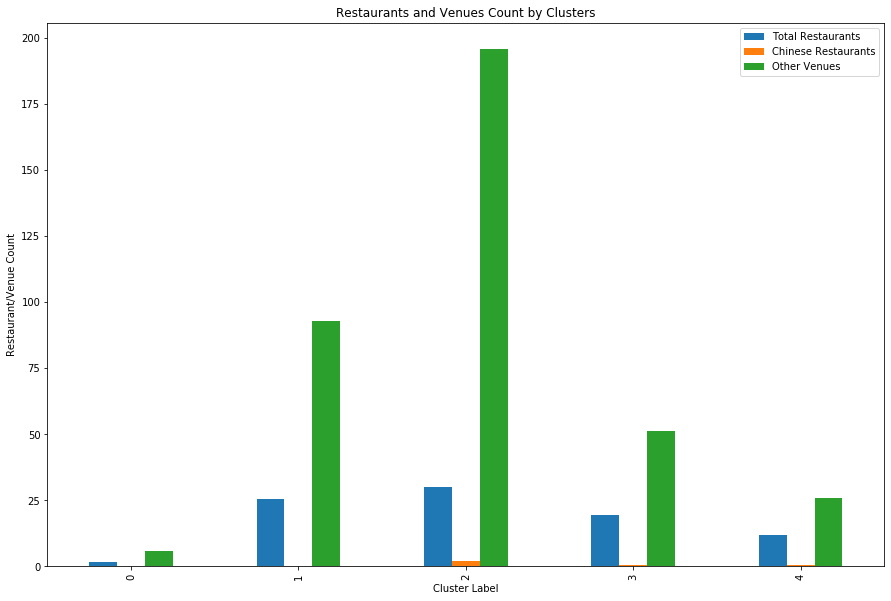

In [61]:
cluster_bar = sfo_clusters[['Cluster', 'Total Restaurants', 'Chinese Restaurants', 'Other Venues']].groupby('Cluster').mean()
cluster_bar.plot.bar(figsize=(15,10))
py.title('Restaurants and Venues Count by Clusters')
py.xlabel('Cluster Label')
py.ylabel('Restaurant/Venue Count')
py.show()

**Plot the neighborhoods in the SFO map classifying the clusters**

In [62]:
#Prepare the map focused on SFO
map_cluster = folium.Map(location=[sfo_lat, sfo_long], zoom_start=13)

#Set colors for clusters
colors_array = cm.rainbow(np.linspace(0, 1, clusters))
color_list = [colors.rgb2hex(i) for i in colors_array]

# Add the marker for the neighborhood in SFO city
for lat, long, name, cluster in zip(sfo_clusters['Latitude'], sfo_clusters['Longitude'], sfo_clusters['Neighborhood'], sfo_clusters['Cluster']):
    label = folium.Popup(name+' - Cluster '+str(cluster), parse_html=True)
    #folium.CircleMarker([lat, long],
    #                    radius=4,
    #                    popup=label,
    #                    color=color_list[cluster]). add_to(map_cluster)
    folium.Circle([lat, long],
                  radius=200,
                  popup=label,
                  color=color_list[cluster],
                  fill=True,
                  fill_color=color_list[cluster],                    
                  fill_opacity=0.2).add_to(map_cluster)

#Display the SFO map with neighborhood markers
map_cluster

**Analyze the data in each cluster**

In [63]:
sfo_clusters[sfo_clusters['Cluster']==0]

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
0,Alamo Square,37.776360,-122.434689,1.0,0.0,14,0
1,Anza Vista,37.780836,-122.443149,1.0,0.0,4,0
2,Balboa Park,37.721427,-122.447547,8.0,1.0,2,0
3,Bayview,37.728889,-122.392500,7.0,0.0,5,0
5,Bernal Heights,37.742986,-122.415804,0.0,0.0,8,0
12,Corona Heights,37.764886,-122.439368,1.0,0.0,12,0
14,Crocker-Amazon,37.709378,-122.438587,0.0,0.0,0,0
16,Dolores Heights,37.743038,-122.424248,4.0,0.0,10,0
25,Forest Hill,37.747431,-122.463583,1.0,0.0,5,0
29,Hunters Point,37.726771,-122.371572,0.0,0.0,0,0


In [64]:
sfo_clusters[sfo_clusters['Cluster']==1]

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
7,Castro,37.760856,-122.434957,35.0,0.0,88,1
13,Cow Hollow,37.797262,-122.436248,15.0,0.0,77,1
18,Embarcadero,37.792864,-122.396912,3.0,0.0,110,1
19,Eureka Valley,37.760956,-122.435509,33.0,0.0,85,1
27,Haight-Ashbury,37.770015,-122.446952,13.0,0.0,102,1
28,Hayes Valley,37.776685,-122.422936,39.0,0.0,108,1
35,Japantown,37.785579,-122.429809,41.0,1.0,81,1


In [65]:
sfo_clusters[sfo_clusters['Cluster']==2]

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
4,Belden Place,37.791744,-122.403886,35.0,0.0,191,2
9,Chinatown,37.794301,-122.406376,26.0,11.0,164,2
22,Financial District,37.793647,-122.398938,36.0,0.0,205,2
23,Financial District South,37.793647,-122.398938,36.0,0.0,205,2
77,Union Square,37.787936,-122.407517,17.0,0.0,214,2


In [66]:
sfo_clusters[sfo_clusters['Cluster']==3]

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
6,Buena Vista,37.806532,-122.420648,17.0,0.0,49,3
21,Fillmore,37.784083,-122.433085,27.0,1.0,56,3
24,Fisherman's Wharf,37.809167,-122.416599,29.0,0.0,38,3
40,Little Saigon,37.784316,-122.416348,22.0,0.0,49,3
42,Lower Haight,37.771926,-122.432479,21.0,1.0,40,3
47,Mission District,37.759930,-122.419138,27.0,2.0,68,3
50,Noe Valley,37.751591,-122.432081,14.0,1.0,57,3
51,North Beach,37.801175,-122.409002,31.0,0.0,54,3
67,South Beach,37.779814,-122.391150,23.0,1.0,63,3
71,Sunnyside,37.779026,-122.419906,7.0,0.0,45,3


In [67]:
sfo_clusters[sfo_clusters['Cluster']==4]

,Neighborhood,Latitude,Longitude,Total Restaurants,Chinese Restaurants,Other Venues,Cluster
8,China Basin,37.776330,-122.391839,12.0,1.0,28,4
10,Civic Center,37.779594,-122.416794,11.0,0.0,36,4
11,Cole Valley,37.765813,-122.449962,10.0,0.0,22,4
15,Dogpatch,37.760698,-122.389202,12.0,0.0,36,4
17,Duboce Triangle,37.767138,-122.432230,6.0,0.0,23,4
20,Excelsior,37.721794,-122.435382,21.0,2.0,15,4
26,Glen Park,37.734281,-122.434470,11.0,1.0,18,4
32,Inner Sunset,37.761450,-122.467643,14.0,0.0,18,4
39,Laurel Heights,37.786804,-122.449820,2.0,0.0,40,4
41,Lone Mountain,37.779096,-122.451916,1.0,0.0,26,4


## Results and Discussion <a name="results"></a>

Based on the K-Means clustering mean distance analysis, the neighborhoods are grouped into 5 clusters. Analyzing these 5 clusters, the cluster with the neighborhoods **Castro, Cow Hollow, Embarcadero, Eureka Valley, Haight-Ashbury, Hayes Valley, Japantown** is selected as one of the best clusters to setup a Chinese/Asian Restaurant.

This cluster has neighborhoods with lot of busy venues where lot of people moving around. At the same time there are no Chinese/Asian restaurants in these neighborhoods. The interesting part of this cluster is, all the neighborhoods has many restaurants except for one. This gives an idea that restaurants in these neighborhoods are a good business and people are interested in visiting the restaurants in these neighborhoods. These neighborhoods can be strongly considered to setup a Chinese/Asian restaurant.

In [68]:
prefer_cluster = sfo_clusters[sfo_clusters['Cluster']==1]

#Prepare the map focused on SFO
prefer_cluster_map = folium.Map(location=[sfo_lat, sfo_long], zoom_start=14)

# Add the marker for the neighborhood in SFO city
for lat, long, name in zip(prefer_cluster['Latitude'], prefer_cluster['Longitude'], prefer_cluster['Neighborhood']):
    label = folium.Popup(name+' - Cluster '+str(cluster), parse_html=True)
    folium.Circle([lat, long],
                  radius=200,
                  popup=label,
                  color='magenta',
                  fill=True,
                  fill_color='magenta',                    
                  fill_opacity=0.2).add_to(prefer_cluster_map)

#Display the SFO map with neighborhood markers
prefer_cluster_map

## Conclusion <a name="conclusion"></a>

This project was done to identify the best locations in the San Francisco city, California to setup a Chinese/Asian Restaurant and run a successfully business. This analysis was done using the neighborhood data from Wikipedia and the venue data from Foursquare. The venue data has been classified as all restaurants, Chinese/Asian restaurants and other busy venues to characterize a specific neighborhood. Based on these characters we formed clusters of neighborhoods. These clusters will be analyzed to determine the perfect neighborhood to setup the restaurant. This project is flexible, and the same process can be used to setup any type restaurant by tweaking the customizable parameters and utilizing the same process.